In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import keras
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
train = datasets.FashionMNIST(root="./", download=True)

100%|████████████████████████████████████████████████████████████████| 26421880/26421880 [00:02<00:00, 10029832.72it/s]


Extracting ./FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST\raw






100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 226663.30it/s]


Extracting ./FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST\raw






100%|███████████████████████████████████████████████████████████████████| 4422102/4422102 [00:02<00:00, 1851102.35it/s]


Extracting ./FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST\raw






100%|█████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 5092518.16it/s]

Extracting ./FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST\raw




In [23]:
len(train)

60000

In [15]:
test = datasets.FashionMNIST(root="./", train=False, download=False)

In [24]:
len(test)

10000

In [3]:
n_epochs = 3
batch_size_train = 60
batch_size_test = 100
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [4]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [31]:
train_loader = DataLoader(datasets.FashionMNIST(root="./", train=True, download=False,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                             ])), batch_size=batch_size_train, shuffle=True)

test_loader = DataLoader(datasets.FashionMNIST(root="./", train=False, download=False,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                             ])), batch_size=batch_size_test, shuffle=True)

In [32]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([100, 1, 28, 28])

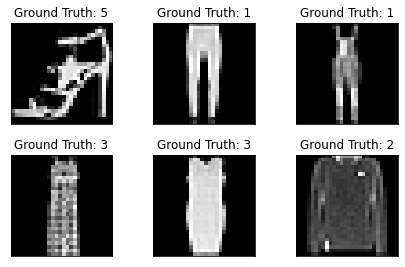

In [11]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [49]:
class Net(nn.Sequential):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # p=0.5
        self.fc1 = nn.Linear(20*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # первый сверточный слой
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # второй сверточный слой
        x = x.view(-1, 20*4*4) # в двухмерный тензор с shape: (batch, 20*4*4)
        x = F.relu(self.fc1(x)) # первый полносвязный слой
        x = F.dropout(x, training=self.training)
        x = self.fc2(x) # второй полносвязный слой
        return F.log_softmax(x)

In [50]:
network = Net()

optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [51]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [52]:
def train(epoch):
    network.train() # has any effect only on certain modules e.g. Dropout, BatchNorm, etc.
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        # negative log likelihood loss. It is useful to train a classification problem with C classe:        
        loss = F.nll_loss(output, target) 
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'results/model.pth')
            torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [53]:
def test(debug=False):
    network.eval() # equivalent with self.train(False)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
    
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()    

            if debug:
                return output
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 
        100. * correct / len(test_loader.dataset)))

In [54]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

<ipython-input-49-f23849e8560b>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.

  return F.log_softmax(x)




Test set: Avg. loss: 2.3097, Accuracy: 462/10000 (5%)



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.334675

Train Epoch: 1 [600/60000 (1%)]	Loss: 2.303204

Train Epoch: 1 [1200/60000 (2%)]	Loss: 2.300982

Train Epoch: 1 [1800/60000 (3%)]	Loss: 2.249619

Train Epoch: 1 [2400/60000 (4%)]	Loss: 2.261330

Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.245739

Train Epoch: 1 [3600/60000 (6%)]	Loss: 2.224122

Train Epoch: 1 [4200/60000 (7%)]	Loss: 2.109695

Train Epoch: 1 [4800/60000 (8%)]	Loss: 2.105176

Train Epoch: 1 [5400/60000 (9%)]	Loss: 2.125035

Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.925489

Train Epoch: 1 [6600/60000 (11%)]	Loss: 1.818796

Train Epoch: 1 [7200/60000 (12%)]	Loss: 1.854240

Train Epoch: 1 [7800/60000 (13%)]	Loss: 1.743614

Train Epoch: 1 [8400/60000 (14%)]	Loss: 1.580690

Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.750482

Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.584072

Train Epoch: 1 [10200/60000 (17%)]	Loss: 1.473156

Train Epoch: 1 [10800/60000 (18%)]	Loss: 1.388261

Tra

In [4]:
from keras.datasets import fashion_mnist, cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

In [58]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [59]:
batch_size, img_rows, img_cols = 60, 28, 28
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [60]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

In [61]:
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [78]:
model = Sequential()

In [79]:
model.add(Flatten(input_shape=input_shape))
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

In [80]:
model.summary()

Model: "sequential_4"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 flatten_4 (Flatten)         (None, 784)               0         

                                                                 

 dense_11 (Dense)            (None, 1024)              803840    

                                                                 

 activation_2 (Activation)   (None, 1024)              0         

                                                                 

 dropout_4 (Dropout)         (None, 1024)              0         

                                                                 

 dense_12 (Dense)            (None, 10)                10250     

                                                                 

 activation_3 (Activation)   (None, 10)                0         

                                                                 


Total params: 814,090

Trainable para

In [81]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=10, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)

# выводим результаты
print("Test loss: %f" % score[0])
print("Test accuracy: %f" % score[1])

Epoch 1/10

1000/1000 [==============================] - 10s 9ms/step - loss: 0.5442 - accuracy: 0.8065 - val_loss: 0.4648 - val_accuracy: 0.8313

Epoch 2/10

1000/1000 [==============================] - 10s 10ms/step - loss: 0.4243 - accuracy: 0.8454 - val_loss: 0.3844 - val_accuracy: 0.8631

Epoch 3/10

1000/1000 [==============================] - 10s 10ms/step - loss: 0.3935 - accuracy: 0.8554 - val_loss: 0.3762 - val_accuracy: 0.8635

Epoch 4/10

1000/1000 [==============================] - 10s 10ms/step - loss: 0.3711 - accuracy: 0.8631 - val_loss: 0.3735 - val_accuracy: 0.8647

Epoch 5/10

1000/1000 [==============================] - 10s 10ms/step - loss: 0.3594 - accuracy: 0.8680 - val_loss: 0.3564 - val_accuracy: 0.8702

Epoch 6/10

1000/1000 [==============================] - 12s 12ms/step - loss: 0.3497 - accuracy: 0.8715 - val_loss: 0.3535 - val_accuracy: 0.8711

Epoch 7/10

1000/1000 [==============================] - 11s 11ms/step - loss: 0.3374 - accuracy: 0.8747 - val_lo

In [86]:
history.history['loss']

[0.5442426204681396,
 0.42425814270973206,
 0.39346086978912354,
 0.37110671401023865,
 0.35935309529304504,
 0.34969213604927063,
 0.3374468684196472,
 0.33203253149986267,
 0.31985482573509216,
 0.3134876489639282]

In [14]:
def loss_graph(loss, range_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range_epochs, loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(range_epochs)
    plt.title("Losses minimization")
    plt.show()

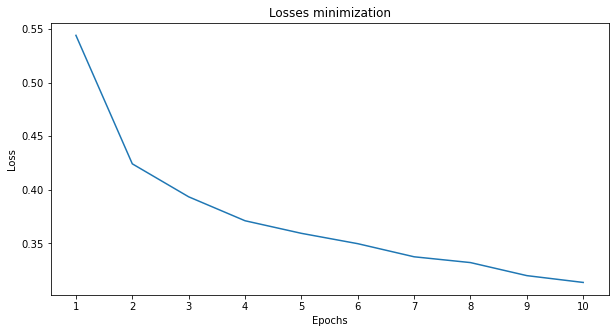

In [92]:
loss_graph(history.history['loss'], range(1, 11))

In [96]:
X_test[0].shape

(28, 28, 1)

In [112]:
output = model(X_test[0:30,:,:,:])
pred = np.argmax(output, axis=1)
pred[0]
np.argmax(Y_test[0])

9

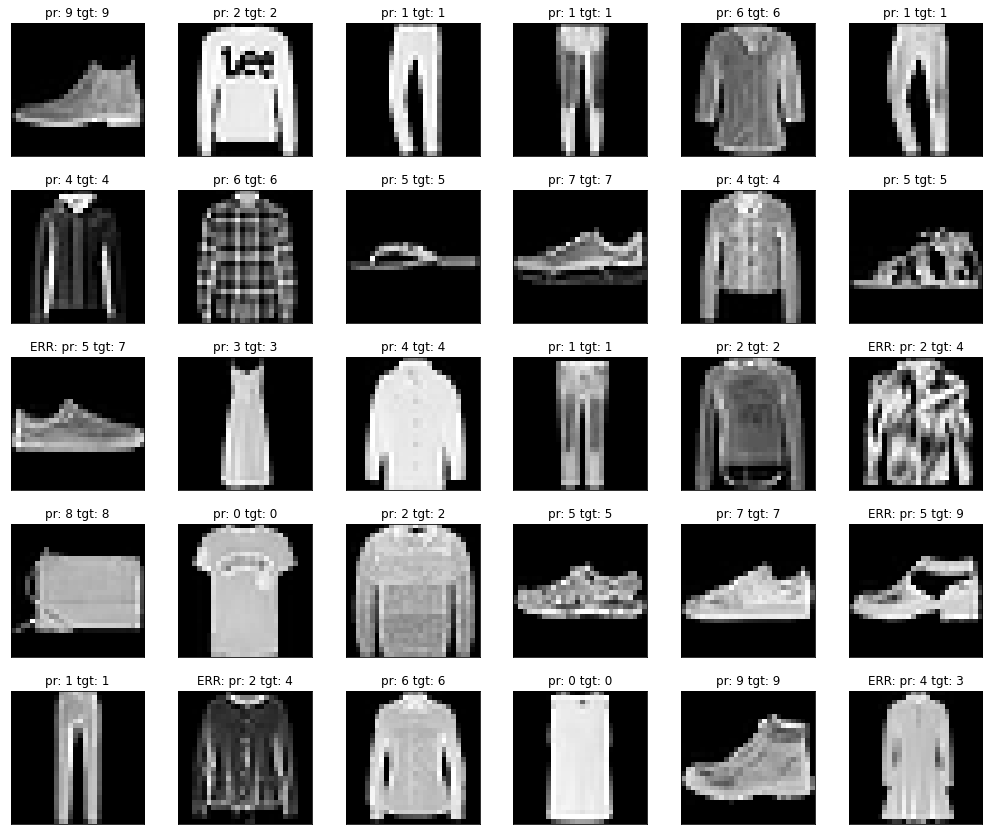

In [117]:
fig = plt.figure(figsize=(14,12))

for i in range(30):
    plt.subplot(5, 6, i+1)
    plt.tight_layout()
    plt.imshow(X_test[0:30,:,:,:][i], cmap='gray', interpolation='none')
    if pred[i] == np.argmax(Y_test[i]):
        plt.title(f"pr: {pred[i]} tgt: {np.argmax(Y_test[i])}")
    else:
        plt.title(f"ERR: pr: {pred[i]} tgt: {np.argmax(Y_test[i])}")        
    plt.xticks([])
    plt.yticks([])

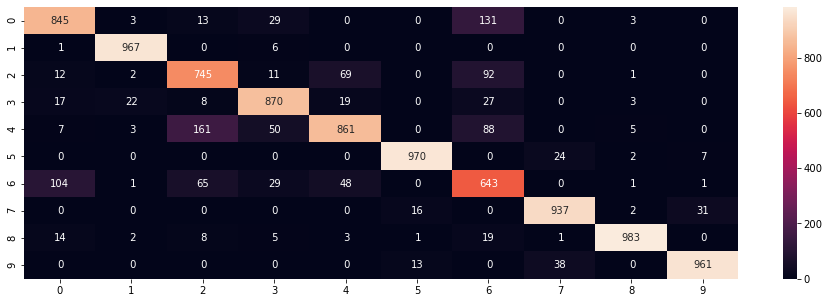

In [127]:
predictions = np.argmax(model(X_test), axis=1)
truth = np.argmax(Y_test, axis=1)
plt.figure(figsize = (16,5))
ax = sns.heatmap(confusion_matrix(predictions, truth), annot=True, fmt='2')

In [128]:
print("Test accuracy: %f" % score[1])

Test accuracy: 0.878200


### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


In [7]:
batch_size, img_rows, img_cols = 50, 32, 32
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

In [8]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

In [9]:
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [10]:
model = Sequential()

model.add(Flatten(input_shape=input_shape))
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 3,157,002
Trainable params: 3,157,002
Non-

In [12]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=10, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)

# выводим результаты
print("Test loss: %f" % score[0])
print("Test accuracy: %f" % score[1])

Epoch 1/10
1000/1000 [==============================] - 27s 26ms/step - loss: 2.0639 - accuracy: 0.2501 - val_loss: 1.8488 - val_accuracy: 0.3317
Epoch 2/10
1000/1000 [==============================] - 26s 26ms/step - loss: 1.9413 - accuracy: 0.2856 - val_loss: 1.8131 - val_accuracy: 0.3614
Epoch 3/10
1000/1000 [==============================] - 25s 25ms/step - loss: 1.9127 - accuracy: 0.2988 - val_loss: 1.7817 - val_accuracy: 0.3666
Epoch 4/10
1000/1000 [==============================] - 26s 26ms/step - loss: 1.8989 - accuracy: 0.3040 - val_loss: 1.7699 - val_accuracy: 0.3690
Epoch 5/10
1000/1000 [==============================] - 26s 26ms/step - loss: 1.8789 - accuracy: 0.3134 - val_loss: 1.7677 - val_accuracy: 0.3697
Epoch 6/10
1000/1000 [==============================] - 25s 25ms/step - loss: 1.8715 - accuracy: 0.3124 - val_loss: 1.7332 - val_accuracy: 0.3839
Epoch 7/10
1000/1000 [==============================] - 26s 26ms/step - loss: 1.8589 - accuracy: 0.3210 - val_loss: 1.7111 -

In [13]:
history.history['loss']

[2.06392765045166,
 1.9413005113601685,
 1.9126861095428467,
 1.8989050388336182,
 1.878941297531128,
 1.871525764465332,
 1.8589414358139038,
 1.8513187170028687,
 1.8416998386383057,
 1.829027533531189]

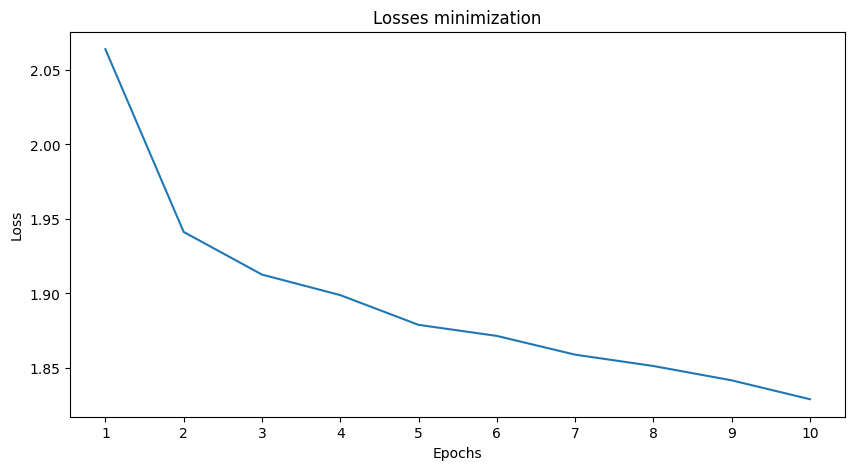

In [15]:
loss_graph(history.history['loss'], range(1, 11))

In [16]:
output = model(X_test[0:30,:,:,:])
pred = np.argmax(output, axis=1)
pred[0]
np.argmax(Y_test[0])

3

/tmp/ipykernel_32/1621158802.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


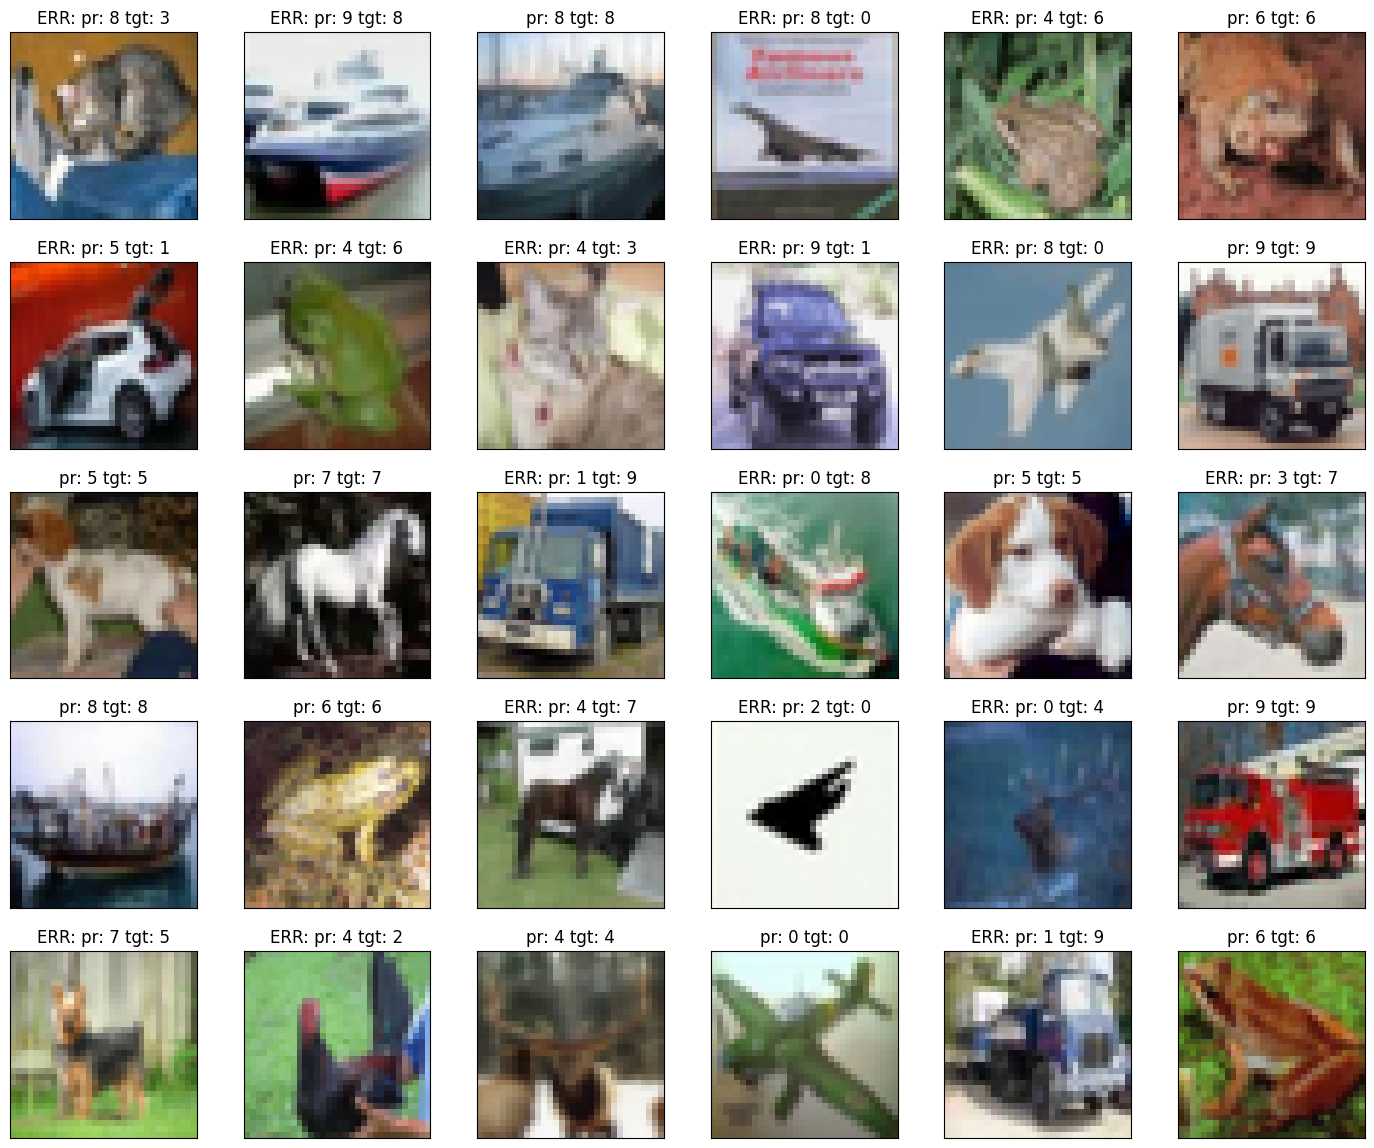

In [17]:
fig = plt.figure(figsize=(14,12))

for i in range(30):
    plt.subplot(5, 6, i+1)
    plt.tight_layout()
    plt.imshow(X_test[0:30,:,:,:][i], cmap='gray', interpolation='none')
    if pred[i] == np.argmax(Y_test[i]):
        plt.title(f"pr: {pred[i]} tgt: {np.argmax(Y_test[i])}")
    else:
        plt.title(f"ERR: pr: {pred[i]} tgt: {np.argmax(Y_test[i])}")        
    plt.xticks([])
    plt.yticks([])

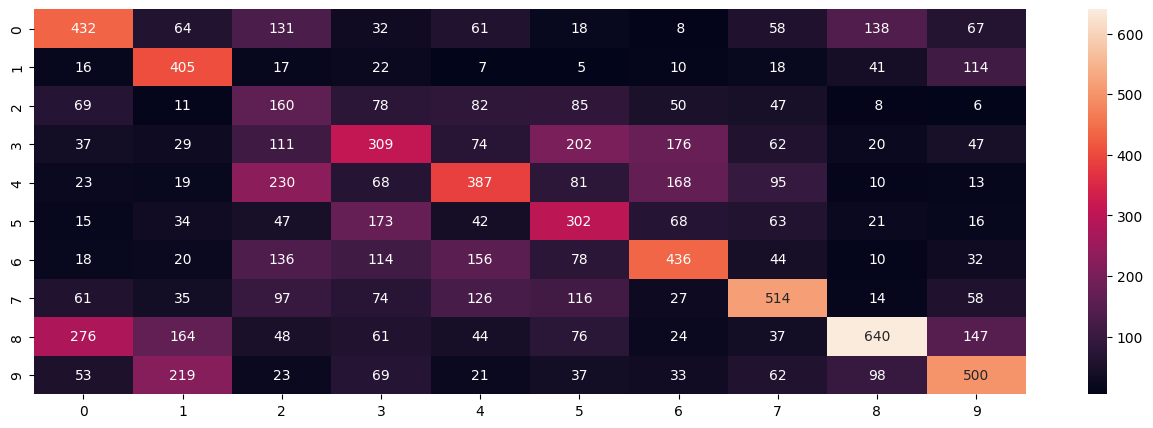

In [18]:
predictions = np.argmax(model(X_test), axis=1)
truth = np.argmax(Y_test, axis=1)
plt.figure(figsize = (16,5))
ax = sns.heatmap(confusion_matrix(predictions, truth), annot=True, fmt='2')

In [19]:
print("Test accuracy: %f" % score[1])

Test accuracy: 0.408500


### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('drive/MyDrive/datasets/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 1371/1371 [00:16<00:00, 81.74it/s]


### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)